In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from transformers import AdamW
import pandas as pd
from transformers import BertTokenizer, BertModel, BertConfig
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import csv
import re
import validators
import emoji
import unidecode
import nltk
import pickle
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mai\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
# Set the seed for reproducibility
SEED = 1237
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# BERT Hyperparameters (ADDITION)
n_bert_layers = 16  # Assuming the base model has 12 layers
bert_lr = 0.001
pooling_strategy = 'cls'  # Options: 'cls', 'mean', 'max'
bert_hidden_size = 768  # Adjust based on your BERT model
max_seq_length = 128
fine_tune_strategy = 'full'  # Options: 'full', 'last_layer'
bert_dropout = 0.9  # Adjust based on BERT model specifications

max_seq_length = 128  # This should match the max_seq_length used in BERT model
padding_strategy = 'max_length'  # Options: 'max_length', 'do_not_pad', 'longest'
truncation_strategy = 'longest_first'  # Options: 'longest_first', 'only_first', 'only_second'
do_lower_case = True  # Set to False if using a cased model

config = BertConfig(
    num_hidden_layers=n_bert_layers,
    hidden_size=bert_hidden_size,
    num_attention_heads=24,  # Assuming 12 attention heads
    intermediate_size=4 * bert_hidden_size,  # Default value in BERT
    hidden_dropout_prob=bert_dropout,
    attention_probs_dropout_prob=bert_dropout,
)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          max_length=max_seq_length,
                                          padding=padding_strategy,
                                          truncation=truncation_strategy,
                                          do_lower_case=do_lower_case)
# Load the BERT model with the custom configuration
bert_model = BertModel(config=config)

In [3]:
data_path = "multilabel-dataset.csv"  
data_df = pd.read_csv(data_path)
data_df = data_df.rename(columns={'Tweet Content': 'text', 'Sentiment': 'sentiment', 'Label': 'label'})

In [4]:
data_df

text sentiment     label
0     Dictator's son on the cusp of power in the #Ph...  Negative      Hate
1     Kung ang definition ni BongBong Marcos sa isan...  Negative      Hate
2     Leni Robredo is not being subjected by her opp...  Negative      Hate
3     @imstillsour Tuwang tuwa sila sa Pink hahaha.....  Negative      Hate
4     Kapag hindi si VP Leni Robredo ang iboboto mo ...  Negative      Hate
...                                                 ...       ...       ...
7675   VP LENI ROBREDO FOR 2022 https://t.co/2ahSefgmST   Neutral  Non-hate
7676  @alt_ego143 @rapplerdotcom @ramboreports hindi...   Neutral  Non-hate
7677  I can't vote yet, but my president is Leni Rob...   Neutral  Non-hate
7678  Anyways President Leni Robredo #SaveLegendsOfT...   Neutral  Non-hate
7679  Kung ayaw nyo d wag nyo iboto.Napaka simple.. ...   Neutral  Non-hate

[7680 rows x 3 columns]

In [5]:
# Preprocessing function
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = tokens[:tokenizer.model_max_length - 2]  # Account for [CLS] and [SEP] tokens
    indexed_tokens = tokenizer.convert_tokens_to_ids(tokens)
    return indexed_tokens

filipino_stopwords = set(
    """
akin
aking
ako
alin
am
amin
aming
ang
ano
anumang
apat
at
atin
ating
ay
bababa
bago
bakit
bawat
bilang
dahil
dalawa
dapat
din
dito
doon
gagawin
gayunman
ginagawa
ginawa
ginawang
gumawa
gusto
habang
hanggang
hindi
huwag
iba
ibaba
ibabaw
ibig
ikaw
ilagay
ilalim
ilan
inyong
isa
isang
itaas
ito
iyo
iyon
iyong
ka
kahit
kailangan
kailanman
kami
kanila
kanilang
kanino
kanya
kanyang
kapag
kapwa
karamihan
katiyakan
katulad
kaya
kaysa
ko
kong
kulang
kumuha
kung
laban
lahat
lamang
likod
lima
maaari
maaaring
maging
mahusay
makita
marami
marapat
masyado
may
mayroon
mga
minsan
mismo
mula
muli
na
nabanggit
naging
nagkaroon
nais
nakita
namin
napaka
narito
nasaan
ng
ngayon
ni
nila
nilang
nito
niya
niyang
noon
o
pa
paano
pababa
paggawa
pagitan
pagkakaroon
pagkatapos
palabas
pamamagitan
panahon
pangalawa
para
paraan
pareho
pataas
pero
pumunta
pumupunta
sa
saan
sabi
sabihin
sarili
sila
sino
siya
tatlo
tayo
tulad
tungkol
una
walang
""".split()
)

# Date De-Identification
def remove_mentions(text):
    mention_pattern = re.compile(r'@\w+')
    
    # Use re.sub to remove mentions
    cleaned_text = mention_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# URL Removal
def remove_url(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    
    # Use re.sub to remove URLs
    cleaned_text = url_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())

    return cleaned_text

# Special Characters Removal
def remove_special_characters(text):
    text = emoji.replace_emoji(text, replace="[emoji]")
    
    # Split the text into words
    words = text.split(" ")
    
    # Initialize an empty string to store the cleaned text
    cleaned_text = ""
    
    # Iterate through each word
    for word in words:
        # Check if the word contains only special characters or "[emoji]"
        if not (re.match(r"^[_\W]+$", word) or "[emoji]" in word):
            if len(cleaned_text) == 0:
                cleaned_text = f"{word}"
            else:
                cleaned_text = f"{cleaned_text} {word}"
                
    # Remove diacritics
    text_no_diacritics = unidecode.unidecode(cleaned_text)

    # Split the text into words
    sentence = text_no_diacritics.split(" ")
    output = ""

    # Remove special characters and numerics
    for part in sentence:
        part = re.sub("[^A-Za-z ]+$", "", part)
        part = re.sub("^[^A-Za-z #]+", "", part)
        if not (len(part) <= 1 or re.match(r"[^a-zA-Z#]", part)):
            if len(output) == 0:
                output = f"{part}"
            else:
                output = f"{output} {part}"

    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(output.split())

    return cleaned_text

# Remove English Stop Words
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')

# Remove English Stop Words
def remove_english_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(filtered_words)
    
    return cleaned_text

# Remove Filipino Stop Words
def remove_filipino_stopwords(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in filipino_stopwords]
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(filtered_words)
  
    return cleaned_text

# Candidate Name Removal
def remove_candidate_names(text):
    candidatelist = "leni robredo bongbong marcos isko moreno domagoso manny pacman pacquiao ping lacson ernie abella leody de guzman norberto gonzales jose montemayor jr faisal mangondato"
    candidatelist = candidatelist.split()
    candidate_pattern = re.compile(r'\b(?:' + '|'.join(map(re.escape, candidatelist)) + r')\b', re.IGNORECASE)
    
    # Use re.sub to remove candidate names
    cleaned_text = candidate_pattern.sub('', text)
    
    # Remove extra spaces and strip leading/trailing spaces
    cleaned_text = ' '.join(cleaned_text.split())
        
    return cleaned_text

# Hashtag Removal
def remove_hashtags(text):
    # Split the text into words
    words = text.split()
    
    # Initialize an empty list to store cleaned words
    cleaned_words = []
    
    for word in words:
        # Check if the word is a hashtag (starts with #)
        if not word.startswith('#'):
            cleaned_words.append(word)
    
    # Join the cleaned words into a single string
    cleaned_text = ' '.join(cleaned_words)
    
    return cleaned_text

In [6]:
# Lowercase except All Capital Words
def lowercase_except_all_caps(text):
    cleaned_text = remove_special_characters(text)
    
    words = cleaned_text.split()
    filtered_words = []
    
    for word in words:
        if word.isupper() and not word.istitle():
            filtered_words.append(word)
        else:
            filtered_words.append(re.sub(r'([A-Z][a-z]+)', lambda x: x.group(1).lower(), word))
            
    return ' '.join(filtered_words)

In [7]:
for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos
https://t.co/5wbFYVWlG4 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista.

EJK sa Drug War at Martial Law mismo ang ebidensya.

#ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... https://t.co/hzn3LiQ5uJ 

Sentiment:  Negative 

-------------------------------------------------

Text:  @imstillsour Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila l

In [8]:
#PreProcessing

In [9]:
# Data De-Identification
data_df['text'] = data_df['text'].apply(remove_mentions)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos https://t.co/5wbFYVWlG4 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista. EJK sa Drug War at Martial Law mismo ang ebidensya. #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... https://t.co/hzn3LiQ5uJ 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink 

In [10]:
# URL Removal
data_df['text'] = data_df['text'].apply(remove_url)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit, nanunupil ng civilian o teenager na NON COMBATANT, pinapatunayan lang na ang PNP-AFP ay terorista. EJK sa Drug War at Martial Law mismo ang ebidensya. #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question... we do not want a puppet president... 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink hahaha😅😂😂 

Sentiment:  Negative 

-------------

In [11]:
# Special Characters Removal
data_df['text'] = data_df['text'].apply(remove_special_characters)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  Dictator's son on the cusp of power in the #Philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  Kung ang definition ni BongBong Marcos sa isang terorista ay isang armadong grupo na nananakit nanunupil ng civilian teenager na NON COMBATANT pinapatunayan lang na ang PNP-AFP ay terorista EJK sa Drug War at Martial Law mismo ang ebidensya #ManggagawaVSMagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  Leni Robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question we do not want puppet president 

Sentiment:  Negative 

-------------------------------------------------

Text:  Tuwang tuwa sila sa Pink hahaha..hindi nila alam Pink color is sign for Bongbong Marcos..kasi favorite nya isuot pink...ambilis ni Leni mag grab ng color kasi nakita nila langit nag Pink 

Sentiment:  Negative 

-------------------------------------

In [12]:
# Lowercase
data_df['text'] = data_df['text'].apply(lowercase_except_all_caps)

for i in range(10):
    text = data_df["text"][i]
    sentiment = data_df["sentiment"][i]

    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

Text:  dictator's son on the cusp of power in the #philippines #marcos 

Sentiment:  Negative 

-------------------------------------------------

Text:  kung ang definition ni bongbong marcos sa isang terorista ay isang armadong grupo na nananakit nanunupil ng civilian teenager na NON COMBATANT pinapatunayan lang na ang PNP-AFP ay terorista EJK sa drug war at martial law mismo ang ebidensya #manggagawaVSmagnanakaw 

Sentiment:  Negative 

-------------------------------------------------

Text:  leni robredo is not being subjected by her opponents to gender attact but her intelligence and capacity to lead are put into question we do not want puppet president 

Sentiment:  Negative 

-------------------------------------------------

Text:  tuwang tuwa sila sa pink hahaha..hindi nila alam pink color is sign for bongbong marcos..kasi favorite nya isuot pink...ambilis ni leni mag grab ng color kasi nakita nila langit nag pink 

Sentiment:  Negative 

-------------------------------------

In [13]:
# Retain Hashtags
#data_df['text'] = data_df['text'].apply(remove_hashtags)

#for i in range(10):
#    text = data_df["text"][i]
#    sentiment = data_df["sentiment"][i]

#    print('Text: ', text, "\n\nSentiment: ", sentiment, "\n\n-------------------------------------------------\n")

In [14]:
data_df.to_csv('pmulti-HTAC7030-UNCASED.csv', index=False)

In [15]:
data_df

text sentiment     label
0     dictator's son on the cusp of power in the #ph...  Negative      Hate
1     kung ang definition ni bongbong marcos sa isan...  Negative      Hate
2     leni robredo is not being subjected by her opp...  Negative      Hate
3     tuwang tuwa sila sa pink hahaha..hindi nila al...  Negative      Hate
4     kapag hindi si VP leni robredo ang iboboto mo ...  Negative      Hate
...                                                 ...       ...       ...
7675                                VP LENI ROBREDO FOR   Neutral  Non-hate
7676  hindi pangngumbinse ang tawag dyan what he is ...   Neutral  Non-hate
7677  can't vote yet but my president is leni robred...   Neutral  Non-hate
7678  anyways president leni robredo #savelegendsoft...   Neutral  Non-hate
7679  kung ayaw nyo wag nyo iboto.napaka simple bast...   Neutral  Non-hate

[7680 rows x 3 columns]

In [16]:
data_df['text'] = data_df['text'].apply(preprocess_text)

In [17]:
data_df.to_csv('pmulti-tokenized-HTAC7030-UNCASED.csv', index=False)

In [18]:
data_df

text sentiment     label
0     [21237, 1005, 1055, 2365, 2006, 1996, 12731, 1...  Negative      Hate
1     [18577, 17076, 6210, 9152, 14753, 18259, 5063,...  Negative      Hate
2     [18798, 2072, 6487, 23417, 2003, 2025, 2108, 1...  Negative      Hate
3     [10722, 16600, 10722, 4213, 9033, 2721, 7842, ...  Negative      Hate
4     [10556, 4502, 2290, 9269, 9033, 21210, 18798, ...  Negative      Hate
...                                                 ...       ...       ...
7675            [21210, 18798, 2072, 6487, 23417, 2005]   Neutral  Non-hate
7676  [9269, 20657, 3070, 25438, 7076, 2063, 17076, ...   Neutral  Non-hate
7677  [2064, 1005, 1056, 3789, 2664, 2021, 2026, 234...   Neutral  Non-hate
7678  [4312, 2015, 2343, 18798, 2072, 6487, 23417, 1...   Neutral  Non-hate
7679  [18577, 1037, 3148, 2860, 6396, 2080, 11333, 2...   Neutral  Non-hate

[7680 rows x 3 columns]

In [19]:
train_df, test_df = train_test_split(data_df, test_size=0.3, random_state=SEED)

In [20]:
### changed output_dim=3, added torch.softmax

In [21]:
# Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_dropout = nn.Dropout(dropout) 
        self.conv1 = nn.Conv1d(in_channels=embedding_dim, out_channels=256, kernel_size=2, padding='same')
        self.pool1 = nn.MaxPool1d(2, 2)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=64, kernel_size=4, padding='same')
        self.global_pooling = nn.AdaptiveMaxPool1d(1)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(64, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.embedding_dropout(embedded)
        x = embedded.permute(0, 2, 1)  # Change the dimensions for convolution
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.global_pooling(x).squeeze(2)
        x = self.dropout(x)
        x = self.fc(x)
        x = torch.softmax(x, dim=1)
        
        return x

In [22]:
# Set up iterators
BATCH_SIZE = 64

In [23]:
### changed "label" to "sentiment"

In [24]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, max_seq_length):
        self.data = dataframe
        self.max_seq_length = max_seq_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx]['text']
        sentiment = self.data.iloc[idx]['sentiment']

        # Padding and conversion to tensor
        padded_text = torch.tensor(text[:self.max_seq_length] + [0] * (self.max_seq_length - len(text)))
        return padded_text, sentiment

In [25]:
train_dataset = TextDataset(train_df, 1000)
test_dataset = TextDataset(test_df, 1000)

In [26]:
train_iterator = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_iterator = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [27]:
# Define model hyperparameters
VOCAB_SIZE = tokenizer.vocab_size
EMBEDDING_DIM = 768
N_FILTERS = 100
FILTER_SIZES = [3, 4, 5]
OUTPUT_DIM = 3
DROPOUT = 0.5

# CNN Hyperparameters
hidden_dim = 100
n_conv_layers = 1
kernel_sizes = [2, 3, 4]
activation = nn.ReLU()

In [28]:
# Initialize CNN model
model = CNN(VOCAB_SIZE, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT)

In [29]:
# Initialize BERT model (for embedding extraction)
bert_model.eval()  # Set to evaluation mode

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.9, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-15): 16 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.9, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.9, inplace=False)
  

In [30]:
with torch.no_grad():
    for i, token in enumerate(tokenizer.get_vocab()):
        token_id = tokenizer.convert_tokens_to_ids(token)
        token_embedding = bert_model.embeddings.word_embeddings.weight[token_id]
        model.embedding.weight[i].data.copy_(token_embedding)

bert_parameters = []
for layer in bert_model.encoder.layer:
    bert_parameters.extend(layer.parameters())

# Create AdamW optimizer with custom hyperparameters for BERT embeddings
bert_learning_rate = 2e-4  # Adjust as needed
bert_optimizer = optim.AdamW(bert_parameters, lr=bert_learning_rate)

In [31]:
#optimizer = optim.Adam(model.parameters())
# Your custom hyperparameters
learning_rate = 0.001
beta_1 = 0.9
beta_2 = 0.999
epsilon = 1e-08
weight_decay = 0.0

# Create Adam optimizer with custom hyperparameters
optimizer = optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1, beta_2), eps=epsilon, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss()

In [32]:
# Create a dictionary to map class labels to numerical indices
label_to_index = {
    "Positive": 0,
    "Negative": 1,
    "Neutral": 2
}

# Train function
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train(model, iterator):
    model.train()
    epoch_loss = 0
    for text_batch, sentiment_batch in iterator:
        # Extract text sequences from the text_batch tensor
        texts = text_batch
        
        # Use numerical labels for multi-class classification
        labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)

        texts = texts.to(device)  # Move to device if needed
        
        optimizer.zero_grad()
        predictions = model(texts).squeeze(1)
        
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    return epoch_loss / len(iterator)


# Evaluate function
def evaluate(model, iterator):
    model.eval()
    epoch_loss = 0
    predicted_sentiments = []
    true_sentiments = []  # Declare the true_sentiments list
    
    with torch.no_grad():
        for text_batch, sentiment_batch in iterator:
            texts = text_batch  # Extract text sequences
            
            # Use numerical labels
            labels = torch.tensor([label_to_index[sentiment] for sentiment in sentiment_batch]).to(device)
            
            texts = texts.to(device)  # Move to device
            
            predictions = model(texts).squeeze(1)
            loss = criterion(predictions, labels)
            
            epoch_loss += loss.item()
            
            # Convert predictions to class labels
            predicted_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in torch.argmax(predictions, dim=1).cpu().numpy()])
            true_sentiments.extend([list(label_to_index.keys())[list(label_to_index.values()).index(idx)] for idx in labels.cpu().numpy()])
    
    # Calculate accuracy, f1, precision, recall
    accuracy = accuracy_score(true_sentiments, predicted_sentiments)
    f1 = f1_score(true_sentiments, predicted_sentiments, average='macro')
    precision = precision_score(true_sentiments, predicted_sentiments, average='macro')
    recall = recall_score(true_sentiments, predicted_sentiments, average='macro')
    
    return epoch_loss / len(iterator), accuracy, f1, precision, recall, predicted_sentiments, true_sentiments

D:\Users\Mai\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\b\abs_abjetg6_iu\croot\pytorch_1686932924616\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


Epoch: 01

	Train Loss: 1.043
	Test Loss: 0.964

	Accuracy: 0.5560 | F1-Score: 0.5333
	Precision: 0.5276 | Recall: 0.5562

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6246    0.7679    0.6889       780
    Negative     0.3770    0.2383    0.2921       772
     Neutral     0.5811    0.6622    0.6190       752

    accuracy                         0.5560      2304
   macro avg     0.5276    0.5562    0.5333      2304
weighted avg     0.5275    0.5560    0.5331      2304


[[599 147  34]
 [263 184 325]
 [ 97 157 498]]


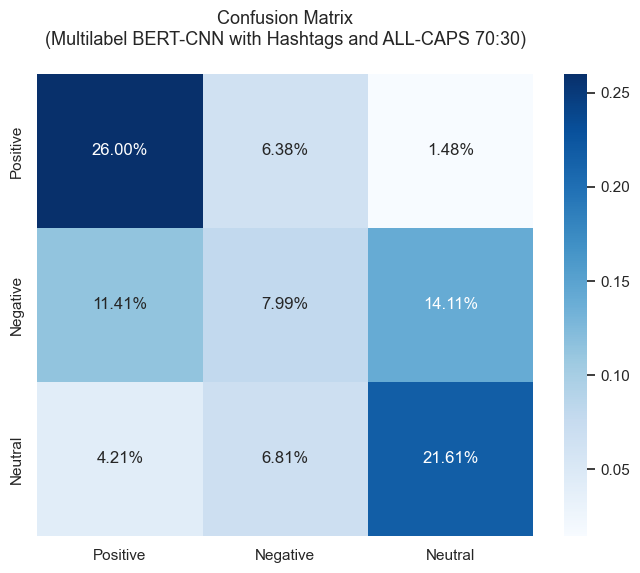

Epoch: 02

	Train Loss: 0.941
	Test Loss: 0.929

	Accuracy: 0.5911 | F1-Score: 0.5803
	Precision: 0.5763 | Recall: 0.5912

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.6876    0.7590    0.7215       780
    Negative     0.4456    0.3446    0.3886       772
     Neutral     0.5957    0.6702    0.6308       752

    accuracy                         0.5911      2304
   macro avg     0.5763    0.5912    0.5803      2304
weighted avg     0.5765    0.5911    0.5804      2304


[[592 154  34]
 [198 266 308]
 [ 71 177 504]]


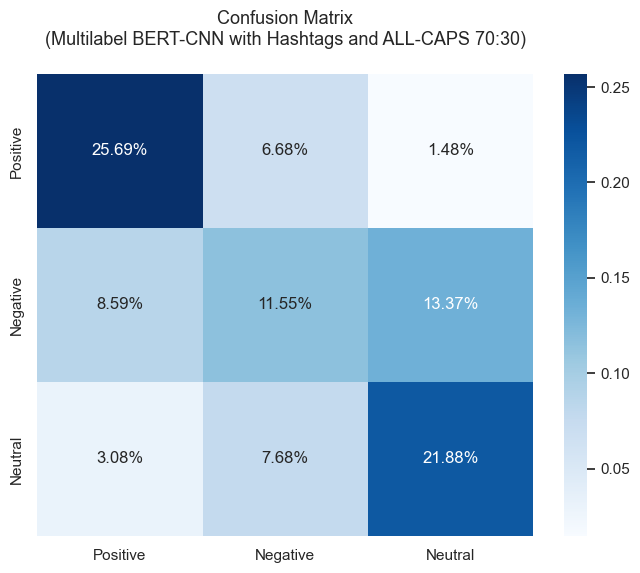

Epoch: 03

	Train Loss: 0.881
	Test Loss: 0.916

	Accuracy: 0.6150 | F1-Score: 0.6105
	Precision: 0.6081 | Recall: 0.6150

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7381    0.7551    0.7465       780
    Negative     0.4728    0.4171    0.4432       772
     Neutral     0.6133    0.6729    0.6417       752

    accuracy                         0.6150      2304
   macro avg     0.6081    0.6150    0.6105      2304
weighted avg     0.6085    0.6150    0.6107      2304


[[589 163  28]
 [159 322 291]
 [ 50 196 506]]


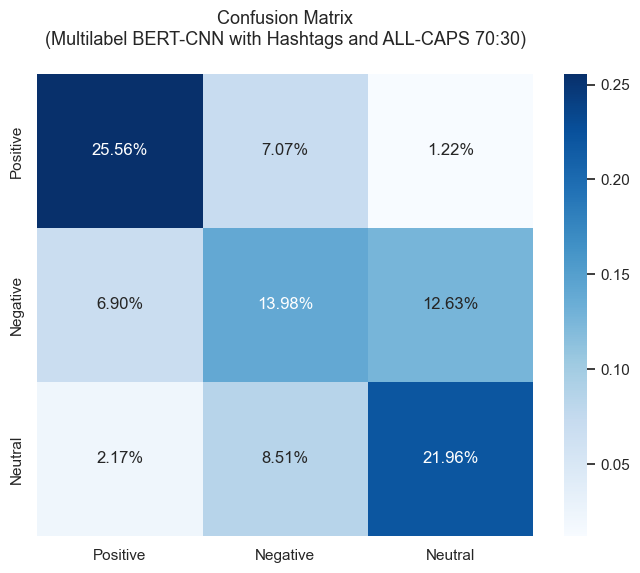

Epoch: 04

	Train Loss: 0.832
	Test Loss: 0.923

	Accuracy: 0.6085 | F1-Score: 0.6122
	Precision: 0.6199 | Recall: 0.6079

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7493    0.7090    0.7286       780
    Negative     0.4637    0.5376    0.4979       772
     Neutral     0.6468    0.5771    0.6100       752

    accuracy                         0.6085      2304
   macro avg     0.6199    0.6079    0.6122      2304
weighted avg     0.6202    0.6085    0.6126      2304


[[553 209  18]
 [138 415 219]
 [ 47 271 434]]


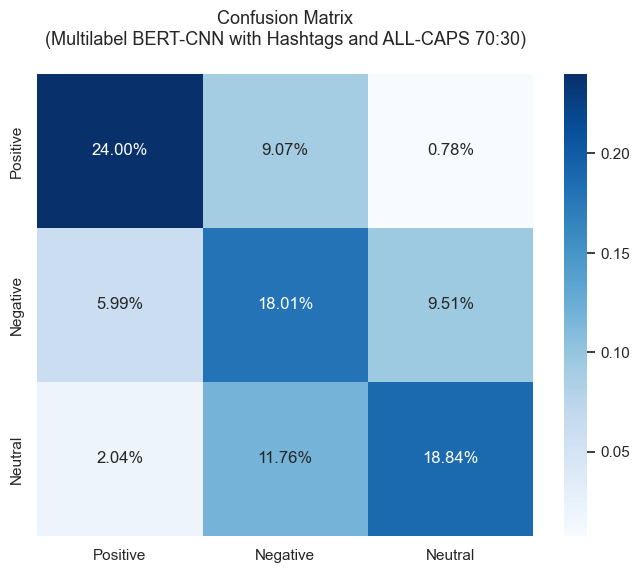

Epoch: 05

	Train Loss: 0.794
	Test Loss: 0.924

	Accuracy: 0.6111 | F1-Score: 0.6151
	Precision: 0.6242 | Recall: 0.6105

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7524    0.7051    0.7280       780
    Negative     0.4670    0.5505    0.5054       772
     Neutral     0.6531    0.5758    0.6120       752

    accuracy                         0.6111      2304
   macro avg     0.6242    0.6105    0.6151      2304
weighted avg     0.6244    0.6111    0.6155      2304


[[550 209  21]
 [138 425 209]
 [ 43 276 433]]


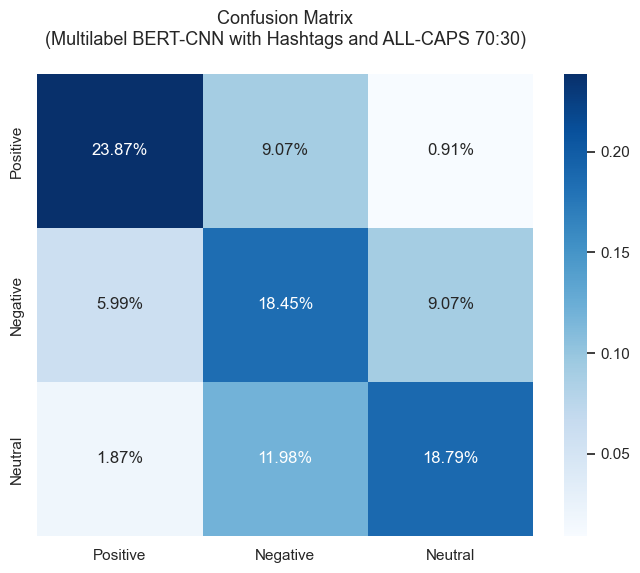

Epoch: 06

	Train Loss: 0.769
	Test Loss: 0.927

	Accuracy: 0.6089 | F1-Score: 0.6142
	Precision: 0.6254 | Recall: 0.6085

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7656    0.6782    0.7192       780
    Negative     0.4655    0.5596    0.5082       772
     Neutral     0.6453    0.5878    0.6152       752

    accuracy                         0.6089      2304
   macro avg     0.6254    0.6085    0.6142      2304
weighted avg     0.6258    0.6089    0.6146      2304


[[529 227  24]
 [121 432 219]
 [ 41 269 442]]


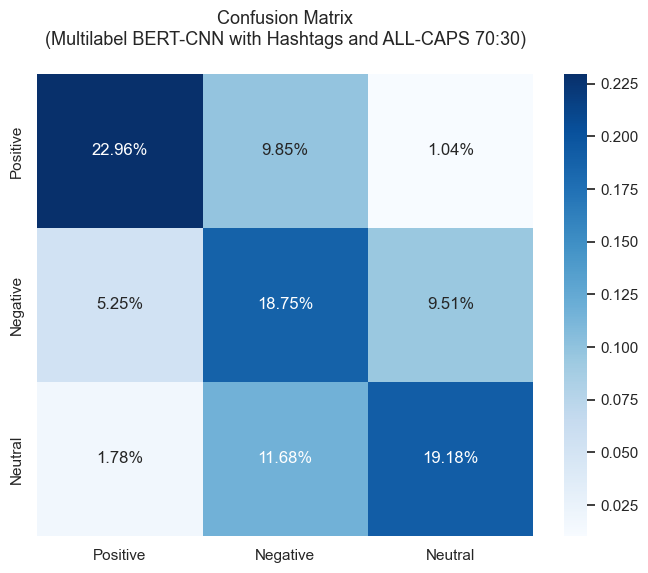

Epoch: 07

	Train Loss: 0.752
	Test Loss: 0.929

	Accuracy: 0.6020 | F1-Score: 0.6092
	Precision: 0.6267 | Recall: 0.6022

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7997    0.6244    0.7012       780
    Negative     0.4542    0.5518    0.4982       772
     Neutral     0.6262    0.6303    0.6282       752

    accuracy                         0.6020      2304
   macro avg     0.6267    0.6022    0.6092      2304
weighted avg     0.6273    0.6020    0.6094      2304


[[487 265  28]
 [ 91 426 255]
 [ 31 247 474]]


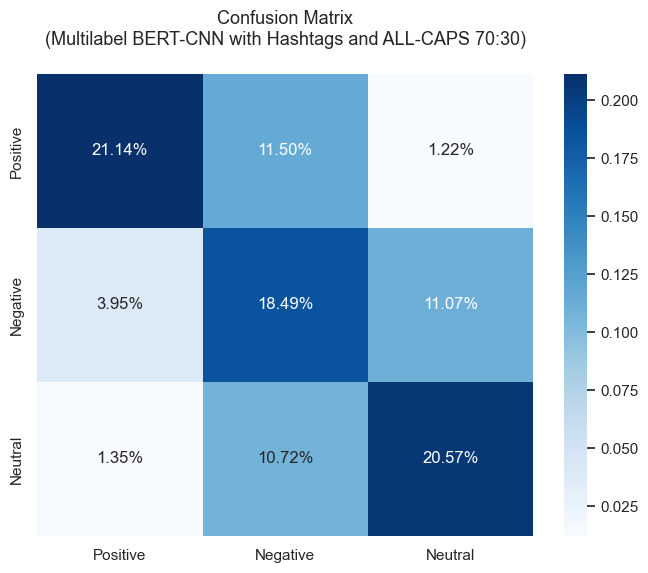

Epoch: 08

	Train Loss: 0.740
	Test Loss: 0.911

	Accuracy: 0.6241 | F1-Score: 0.6216
	Precision: 0.6217 | Recall: 0.6233

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7156    0.7808    0.7468       780
    Negative     0.5020    0.5000    0.5010       772
     Neutral     0.6477    0.5891    0.6170       752

    accuracy                         0.6241      2304
   macro avg     0.6217    0.6233    0.6216      2304
weighted avg     0.6218    0.6241    0.6221      2304


[[609 143  28]
 [173 386 213]
 [ 69 240 443]]


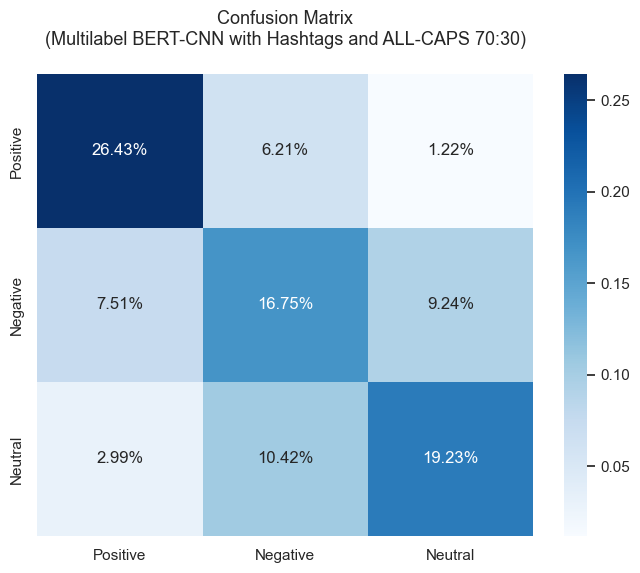

Epoch: 09

	Train Loss: 0.720
	Test Loss: 0.905

	Accuracy: 0.6332 | F1-Score: 0.6346
	Precision: 0.6418 | Recall: 0.6323

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7398    0.7474    0.7436       780
    Negative     0.5040    0.5777    0.5383       772
     Neutral     0.6815    0.5718    0.6218       752

    accuracy                         0.6332      2304
   macro avg     0.6418    0.6323    0.6346      2304
weighted avg     0.6417    0.6332    0.6351      2304


[[583 174  23]
 [148 446 178]
 [ 57 265 430]]


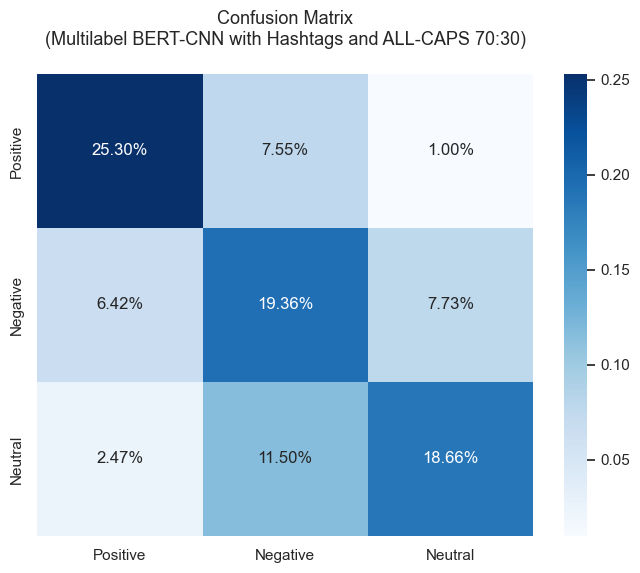

Epoch: 10

	Train Loss: 0.715
	Test Loss: 0.915

	Accuracy: 0.6211 | F1-Score: 0.6235
	Precision: 0.6432 | Recall: 0.6198

	Classification Report:

              precision    recall  f1-score   support

    Positive     0.7523    0.7244    0.7381       780
    Negative     0.4820    0.6256    0.5445       772
     Neutral     0.6951    0.5093    0.5879       752

    accuracy                         0.6211      2304
   macro avg     0.6432    0.6198    0.6235      2304
weighted avg     0.6431    0.6211    0.6242      2304


[[565 199  16]
 [137 483 152]
 [ 49 320 383]]


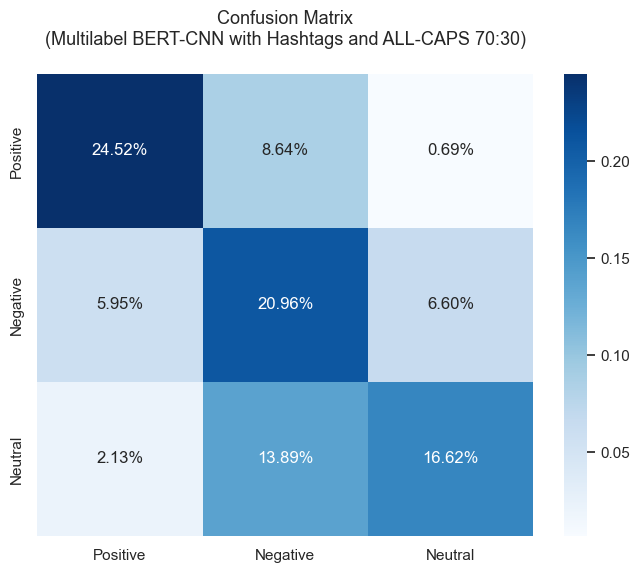

In [33]:
from sklearn.metrics import classification_report

N_EPOCHS = 10
predicted_sentiments_per_epoch = []
true_sentiments_per_epoch = []

for epoch in range(N_EPOCHS):
    train_loss = train(model, train_iterator)
    test_loss, accuracy, f1, precision, recall, predicted_sentiments, true_sentiments = evaluate(model, test_iterator)
    
    # Save the predicted_sentiments and true_sentiments for the current epoch
    predicted_sentiments_per_epoch.append(predicted_sentiments)
    true_sentiments_per_epoch.append(true_sentiments)

    # Print other metrics (e.g., accuracy, loss) for the current epoch
    print(f'Epoch: {epoch + 1:02}\n')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tTest Loss: {test_loss:.3f}\n')
    print(f'\tAccuracy: {accuracy:.4f} | F1-Score: {f1:.4f}')
    print(f'\tPrecision: {precision:.4f} | Recall: {recall:.4f}\n')
    print(f'\tClassification Report:\n')
    report = classification_report(true_sentiments, predicted_sentiments, target_names=['Positive', 'Negative', 'Neutral'], digits = 4)
    print(f'{report}\n')
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np  # Import numpy for matrix normalization

    # Calculate the confusion matrix
    cf_matrix = confusion_matrix(true_sentiments, predicted_sentiments)
    print(cf_matrix)

    # Plot the confusion matrix using seaborn
    sns.set(rc={"figure.figsize": (8, 6)})  # Add a closing parenthesis to set
    ax = sns.heatmap(cf_matrix / np.sum(cf_matrix), annot=True, xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'], fmt='.2%', cmap='Blues')

    plt.title('Confusion Matrix\n(Multilabel BERT-CNN with Hashtags and ALL-CAPS 70:30)\n', fontsize=13)
    plt.show()